In [1]:
%pip install sktime pmdarima tbats;

Note: you may need to restart the kernel to use updated packages.


Імпортуємо дані

In [2]:
import pandas as pd
import matplotlib as plt
import sklearn
from sktime.utils.plotting import plot_series

In [3]:
data = pd.read_csv('myplot.csv')

In [4]:
data['date']

0      2021-11-23
1      2021-11-23
2      2021-11-23
3      2021-11-23
4      2021-11-23
          ...    
346    2021-12-18
347    2021-12-18
348    2021-12-18
349    2021-12-18
350    2021-12-18
Name: date, Length: 351, dtype: object

Групуємо дані по місту

In [5]:
cities_names = data['city'].unique()
cities_names

array(['"KHA"', '"LV"', '"MAD"', '"CV"', '"MAN"', '"BAR"', '"KYV"',
       '"LND"', '"AU"', '"NY"', '"WR"', '"WA"', '"PAR"'], dtype=object)

In [6]:
def make_date_as_index(df):
    """Convert date column to index."""
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date').to_period('D')
    return df

In [7]:
def resample_data(df):
    df = df['click_price'].resample('D').mean().fillna(df['click_price'].mean())
    return df

In [8]:
data_by_cities = {}

for city in cities_names:
    df = make_date_as_index(data.loc[data['city'] == f'{city}'])
    df = resample_data(df)
    data_by_cities[city] = df
data_by_cities

<ipython-input-6-5ea1f4329e2a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


{'"KHA"': date
 2021-10-20    0.700000
 2021-10-21    0.577867
 2021-10-22    0.577867
 2021-10-23    0.577867
 2021-10-24    0.577867
                 ...   
 2021-12-15    0.502222
 2021-12-16    0.601111
 2021-12-17    0.700000
 2021-12-18    0.486296
 2021-12-19    0.700000
 Freq: D, Name: click_price, Length: 61, dtype: float64,
 '"LV"': date
 2021-10-20    0.504000
 2021-10-21    0.461817
 2021-10-22    0.461817
 2021-10-23    0.461817
 2021-10-24    0.461817
                 ...   
 2021-12-15    0.437500
 2021-12-16    0.470750
 2021-12-17    0.504000
 2021-12-18    0.420500
 2021-12-19    0.504000
 Freq: D, Name: click_price, Length: 61, dtype: float64,
 '"MAD"': date
 2021-10-20    0.503333
 2021-10-21    0.470438
 2021-10-22    0.470438
 2021-10-23    0.470438
 2021-10-24    0.470438
                 ...   
 2021-12-15    0.505000
 2021-12-16    0.504167
 2021-12-17    0.503333
 2021-12-18    0.473611
 2021-12-19    0.503333
 Freq: D, Name: click_price, Length: 61, dtype: fl

Отримуємо прогноз для кожного міста

In [9]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.compose import EnsembleForecaster
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.utils.plotting import plot_series
import seaborn as sns
import warnings

sns.set(rc={'figure.figsize':(12,6)})


def get_prediction(city_name):
    data_for_city = data_by_cities[city_name]
    train_data = data_for_city[:'2021-12-17']
    test_data = data_for_city['2021-12-15':]

    print(f"Прогноз вартості одного кліка для {city_name}")
    fh_abs = ForecastingHorizon([i for i in range(10)], is_relative=True)   
    print(f"\nПрогноз на днів вперед: {list(fh_abs)}")

    ensemble = EnsembleForecaster(forecasters = [("tbats", TBATS()),
                                                 ("theta", ThetaForecaster(sp=4)),
                                                 ("ets", ExponentialSmoothing(trend="add", sp=4)),
                                                ],                         
                                  aggfunc = "min")
    forecaster = ensemble.fit(train_data)
    y_pred1 = forecaster.predict(fh=fh_abs)

    warnings.filterwarnings("ignore", category=UserWarning)
    plot_series(train_data, test_data, y_pred1,
                labels=["навчальні дані", "очікувані", "передбачення"]);
    

Прогноз вартості одного кліка для "KHA"

Прогноз на днів вперед: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


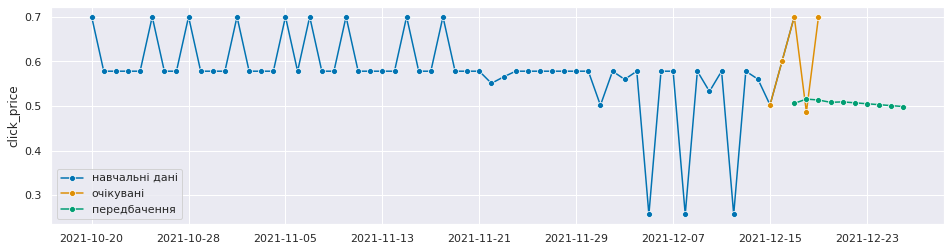

In [10]:
get_prediction(cities_names[0])

Прогноз вартості одного кліка для "LV"

Прогноз на днів вперед: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


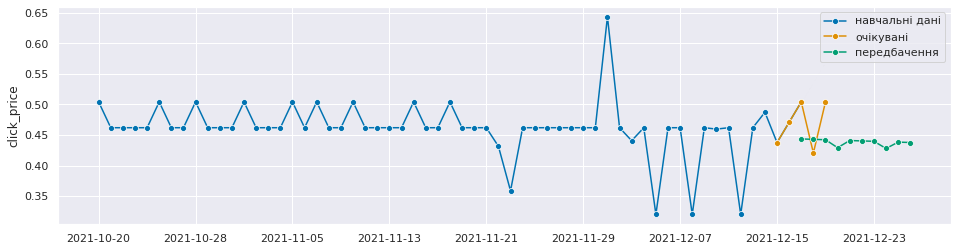

In [11]:
get_prediction(cities_names[1])

Прогноз вартості одного кліка для "MAD"

Прогноз на днів вперед: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


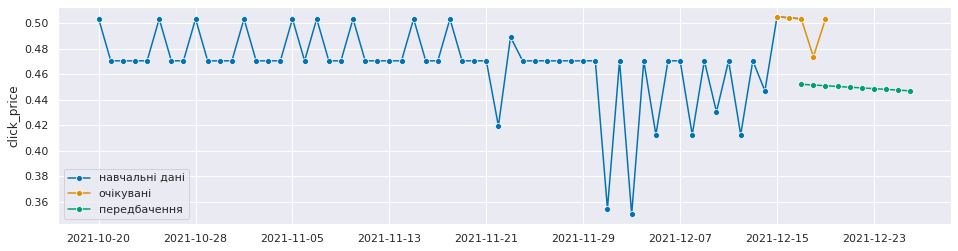

In [12]:
get_prediction(cities_names[2])

Прогноз вартості одного кліка для "CV"

Прогноз на днів вперед: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


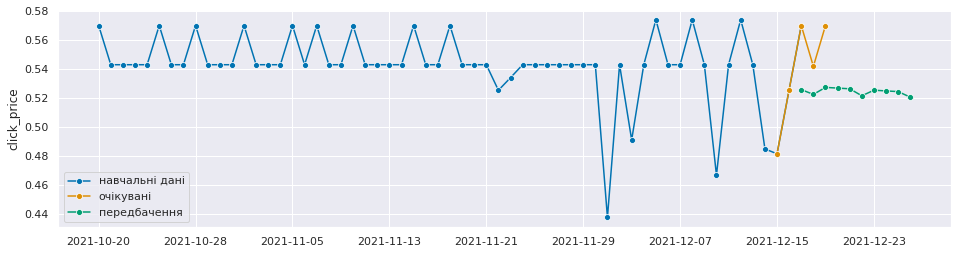

In [13]:
get_prediction(cities_names[3])

Прогноз вартості одного кліка для "MAN"

Прогноз на днів вперед: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


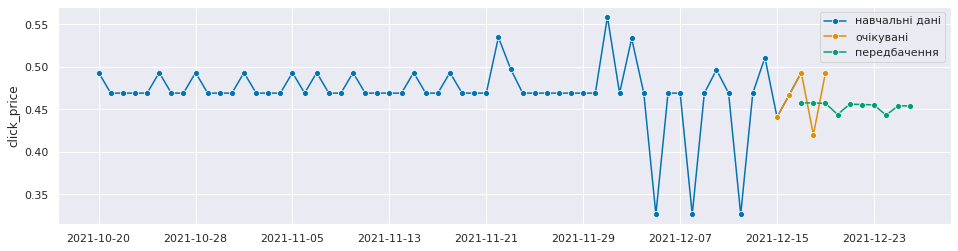

In [14]:
get_prediction(cities_names[4])

Прогноз вартості одного кліка для "BAR"

Прогноз на днів вперед: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


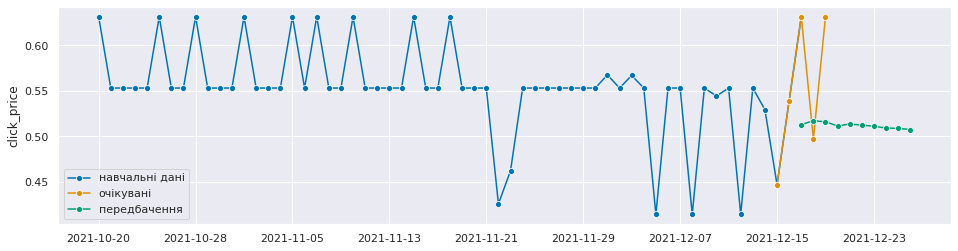

In [15]:
get_prediction(cities_names[5])

Прогноз вартості одного кліка для "KYV"

Прогноз на днів вперед: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


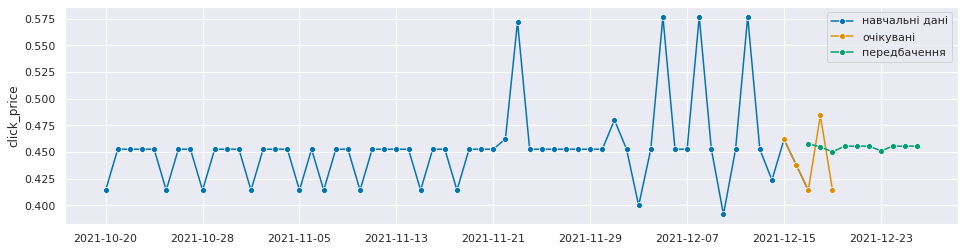

In [16]:
get_prediction(cities_names[6])

Прогноз вартості одного кліка для "LND"

Прогноз на днів вперед: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


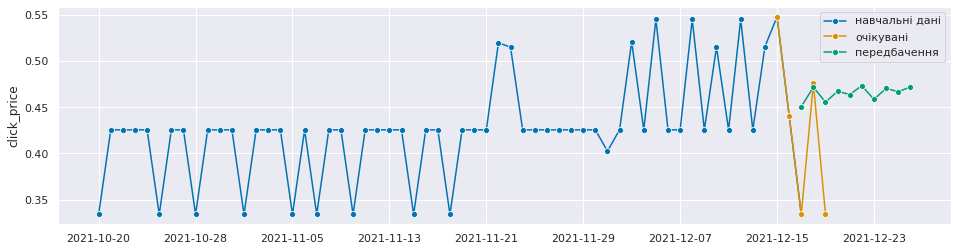

In [17]:
get_prediction(cities_names[7])

Прогноз вартості одного кліка для "AU"

Прогноз на днів вперед: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


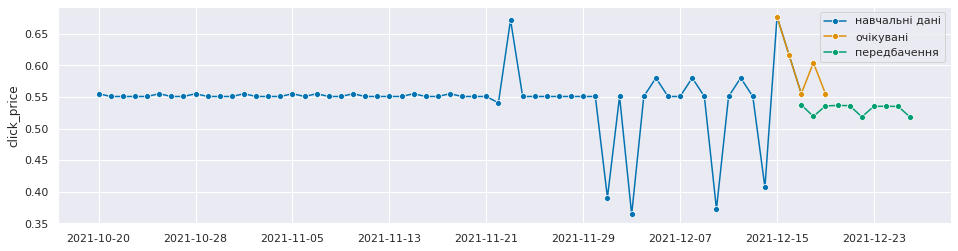

In [18]:
get_prediction(cities_names[8])

Прогноз вартості одного кліка для "NY"

Прогноз на днів вперед: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


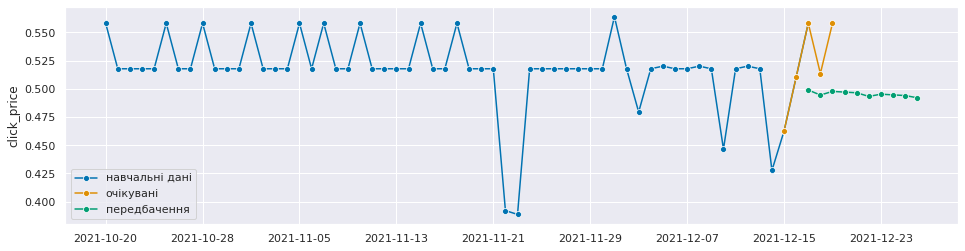

In [19]:
get_prediction(cities_names[9])

Прогноз вартості одного кліка для "WR"

Прогноз на днів вперед: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


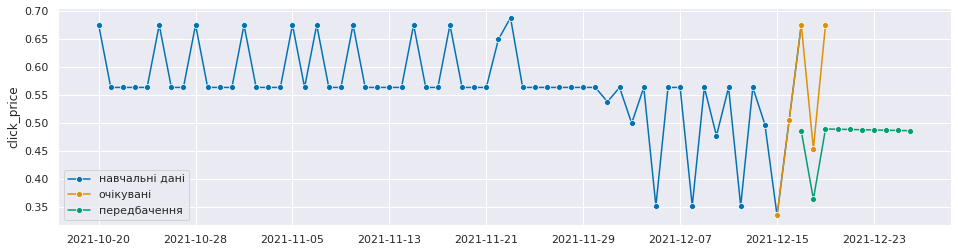

In [20]:
get_prediction(cities_names[10])

Прогноз вартості одного кліка для "WA"

Прогноз на днів вперед: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


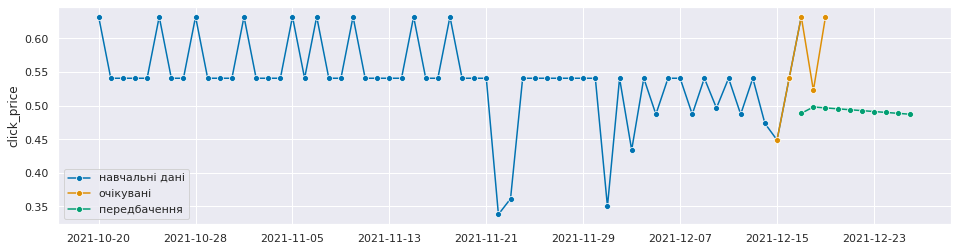

In [21]:
get_prediction(cities_names[11])

Прогноз вартості одного кліка для "PAR"

Прогноз на днів вперед: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


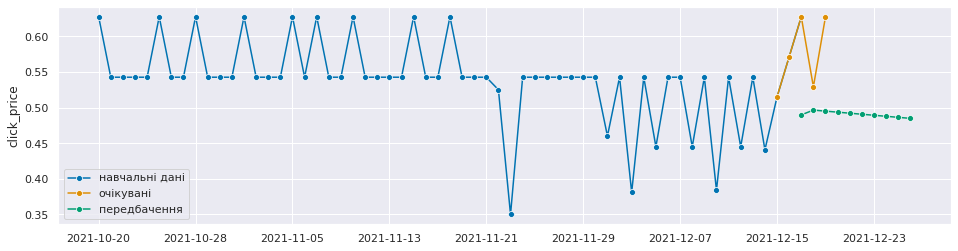

In [22]:
get_prediction(cities_names[12])